<a href="https://colab.research.google.com/github/AtharvaTambat/WnCC-SoC-2022-QML/blob/main/Variational_Quantum_Algorithm_for_Molecular_Geometry_Optimization_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**
Classical algorithms for predicting the equilibrium geometry of molecules require expensive wavefunction methods that become impractical after just a few molecules.They typically rely on the Newton-Raphson method requiring access to the nuclear gradients and the Hessian of the energy at each optimization step while searching for the global minimum along the potential energy surface. Instead, density functional theory methods are used to obtain approximated geometries.


> Here, we introduce a variational quantum algorithm for finding the equilibrium molecular structure of $H_{3}^{+}$ by minimizing the expected (average) value of energy of the Hamiltonian



# **The Algorithm In a Nutshell** 🥥

1.   Build a parameterized Hamiltonian using [Jordan-Wigner transformation](https://en.wikipedia.org/wiki/Jordan%E2%80%93Wigner_transformation).
2.   Build a trial ground state wavefunction using [Givens Rotation](https://pennylane.ai/qml/demos/tutorial_givens_rotations.html) on a Basis Set of qubits containing the parameters $\theta_1$ and $\theta_2$, with respect to which the hamiltonian has to be optimized. For example: 

> $\vert\Psi(\theta_1, \theta_2)\rangle =
\mathrm{cos}(\theta_1)\mathrm{cos}(\theta_2)\vert110000\rangle -
\mathrm{cos}(\theta_1)\mathrm{sin}(\theta_2)\vert000011\rangle -
\mathrm{sin}(\theta_1)\vert001100\rangle$

3. Define a cost function $g(\theta, x) = \langle \Psi(\theta) \vert H(x) \vert\Psi(\theta) \rangle$.

4. Minimize the cost function jointly with respect to the nuclear coordinates $x$ (array of 3D coordinates of all the nuclei) and the parameters $\theta_1$ and $\theta_2$ of the wavefunction.






# **Building a Parameterized Hamiltonian**

1. We first describe the $H_{3}^{+}$ molecule by intializing a set of symbols representing the atom and an array of the initial coordinates of the atoms in 3D.

In [4]:
from pennylane import numpy as np

symbols = ["H", "H", "H"]
x = np.array([0.028, 0.054, 0.0, 0.986, 1.610, 0.0, 1.855, 0.002, 0.0], requires_grad=True) 

2. We then use the molecular_hamiltonian() function of to build the molecular hamiltonian of $H_{3}^{+}$ - inside the function H(x) that we have defined. 

> **THEORY:** Jordan_Wigner transformation is used to represent a fermionic Hamiltonian in terms of linear combination of Pauli Matrices ($\{I, X, Y, Z\}$). 
> 
$\ \ \ \ \ \ \ \ \ H(x) = \sum_j h_j(x) \prod_i^{N} \sigma_i^{(j)}$
> **NOTE:**
> 1.   $h_j(x)$ is the coeffecient of the $j^{th}$ term in the expansion of the hamiltonian $H(x)$ .
2.   $\sigma_i$ is the Pauli Operator from the group $\{I, X, Y, Z\}$
3. N is the number of qubits required to represent the electronic wave function (here, N = 6).















In [5]:
import pennylane as qml 

# Function to generate a molecular hamiltonian from the given atoms, initial set of coordinates and net charge on the molecule
def H(x):
    return qml.qchem.molecular_hamiltonian(symbols, x, charge=1)[0]

# **Building a Trial Ground State Wavefunction** 
1. In ground state $H_3^{+}$, we have two electrons, which have in total 6 "places" (3 orbitals $\cdot$  2 $e^{-}$ per orbital) to occupy.
2. Two places in the computational basis state $|c_1c_2c_3c_4c_5c_6\rangle$ can be assigned to each H-atom in $H_3^{+}$. We assume that the places $\{c_{2i-1},c_{2i}\}$ from the list, are assigned to $H_{i}$ (H-atom, numbered $i$).
3. Here, $|110000\rangle$ denotes that the 2 $e^{-}$ reside on H-atom number 1.

The ground state wavefunction of $H_3^{+}$ consists of not only this state but, a linear combination of all the possible permutations of $|110000\rangle$, signifying electrons residing on different H-atoms.



> $\psi = \sum_j a_j |p_j\rangle $
where, $p_j$ is a permutation of (1,1,0,0,0,0) - each of which represents a compuational basis state.

\\

## **Double and Single Givens Rotation/ Excitation**
The permutations required and the linear combinations can be produced simultaneously by using ***excitation gates***. 



> Consider $G(\theta) = \begin{bmatrix}
1&0&0&0\\
0&cos(\theta)&-sin(\theta)&0\\
0&sin(\theta)&cos(\theta)&0\\
0&0&0&1\\
\end{bmatrix}$. 
> This is a two qubit gate, which transorms $|10\rangle$ to $-sin(\theta)|01\rangle + cos(\theta)|10\rangle$. Since, it permutes only 1 $e^{-}$, it is called a ***single-excitation gate.***

So, it does two things at once - excitation and producing linear superposition/ combination of states representing different occupancy of orbitals by $e^{-}$

Similarly, double-excitation gate $G^{(2)}$ couples the states $|1100\rangle$ and $|0011\rangle$ differing by a **double excitation.**



> $G^{(2)}|1100\rangle = cos(\theta)|1100\rangle − sin(\theta)|0011\rangle$

> $G^{(2)}|0011\rangle = cos(\theta)|0011\rangle + sin(\theta)|1100\rangle$











In [6]:
# Generates the occupation-number vector (not the simulated wavefunction) representing the Hartree-Fock state |110000>
hf = qml.qchem.hf_state(electrons=2, orbitals=6)
print(hf)

[1 1 0 0 0 0]


## **Adaptive Algorithm** 
Instead of using all the double and single excitations to produce the wavefunction, we use a simple shortcut, to reduce the gate count:

1. Generate all possible double excitations of the
Hartree-Fock reference state. Typically, the dominant contributions to the ground-state correlation energy around the equilibrium geometry comes
from the double excitations of the reference state.

2. Make a circuit to simulate the wavefunction, and compute the gradient of the cost function with respect to each double-excitation. Retain only those with a non-zero gradient.

3. Optimize the parameters of the selected double optimization gates.

4. Generate all single excitations of the Hartree-Fock
state. Include the optimized double-excitation
operations in the circuit. Apply all the single-excitation gates and select those with non-zero gradient.

5. Build the final variational quantum circuit by including the selected excitations.

On running the above algorithm for $H_3^{+}$, it turns out that only two double-excitation gates, and no single-excitation gates are required.

In [7]:
# Making the quantum circuit to simulate wavefunction
dev = qml.device("default.qubit", wires=6)

# The function inputs:
# params - an array consisting of theta_1 and theta_2 for creating the linear superposition as explained before
# obs - the observable whose expectation value is to be measured and returned
# wires - array representing the wires, on which operations are to be done
@qml.qnode(dev)
def circuit(params, obs, wires):
    qml.BasisState(hf, wires=wires) # Creates the simulated wavefunction corresponding to the numbers in vector hf
    
    # Generates excitations 
    qml.DoubleExcitation(params[0], wires=[0, 1, 2, 3])
    qml.DoubleExcitation(params[1], wires=[0, 1, 4, 5])

    return qml.expval(obs)

# Draw the circuit for dummy values of parameters theta_1 and theta_2
params = [0.1,0.3]
hamiltonian = H(x)
drawer = qml.draw(circuit)
print(drawer(params, obs = hamiltonian, wires=range(6)))

0: ─╭BasisState(M0)─╭G²(0.10)─╭G²(0.30)─┤ ╭<𝓗>
1: ─├BasisState(M0)─├G²(0.10)─├G²(0.30)─┤ ├<𝓗>
2: ─├BasisState(M0)─├G²(0.10)─│─────────┤ ├<𝓗>
3: ─├BasisState(M0)─╰G²(0.10)─│─────────┤ ├<𝓗>
4: ─├BasisState(M0)───────────├G²(0.30)─┤ ├<𝓗>
5: ─╰BasisState(M0)───────────╰G²(0.30)─┤ ╰<𝓗>


**NOTE:** Double-excitation gate, applied to the wires = [0,1,2,3], new state obtained by excitation of $e^{-}$s from wires *0, 1* to *2, 3*; and a superposition with the original state is created.


---


The circuit prepares the trial state:

$\ \ \ \ \ \ \ \ \ \ \ \ \vert\Psi(\theta_1, \theta_2)\rangle =
\mathrm{cos}(\theta_1)\mathrm{cos}(\theta_2)\vert110000\rangle -
\mathrm{cos}(\theta_1)\mathrm{sin}(\theta_2)\vert000011\rangle -
\mathrm{sin}(\theta_1)\vert001100\rangle$

where $\theta_1$ and $\theta_2$ are the circuit parameters that need to be optimized to find the ground-state energy of the molecule.

# **Defining the cost function** 💰 💸
1. The cost function for this algorithm is $g(\theta, x) = \langle \Psi(\theta) \vert H(x) \vert\Psi(\theta) \rangle$ - the expectation value of the Hamiltonian - which is the total average energy of the molecule.It is the this that we have to minimize in order to find the equilibrium configuration of $H_3^{+}$. So, this serves as a good cost function.



In [8]:
# Defining the cost function 
def cost(params, x):
    hamiltonian = H(x)
    return circuit(params, obs=hamiltonian, wires=range(6))

2. To minimize the cost function by Gradient Descent method, we need to calculate the gardient with respect to both the parameters $\theta$ and $x$ (which is not a scalar).

*   Gradients with respect to $\theta$ are calculated analytically using the automatic differentiation techniques.
*   Gradients with respect to $x$ are calculate using the following user-defined functions, by taking expectation value of gradient of the hamiltonian H(x).

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \nabla_x g(\theta, x) = \langle \Psi(\theta) \vert \nabla_x H(x) \vert \Psi(\theta) \rangle$



In [9]:
# To calculate the gradient wrt all three spatial coordinates (x, y, z)

# The function takes inputs:
# f - function, whose gradient has to be calculated. f takes an array argument - [x_1, y_1, z_1, x_2, y_2, z_2, x_3, y_3, z_3]
# x - array [x_1, y_1, z_1, x_2, y_2, z_2, x_3, y_3, z_3], which represents coordinates of the three H - atoms
# delta - the small change in coordinates for calculating gradient
def gradient(f, x, delta = 0.01):
  gradient = [] # To store the gradient in the form [delH/delx_1, delH/dely_1...delH/delz_3]

  for i in range(len(x)):
    shift = np.zeros_like(x) # creates an empty array with 9 zeroes - [0,0...0]
    shift[i] += 0.5 * delta # creates an array for creating a delta shift in the i^{th} coordinate
    grad_value = (f(x + shift) - f(x - shift))* (delta**(-1)) # Partial gradient wrt x_i - (f(x + delta/2) - f(x - delta/2))/delta 
    gradient.append(grad_value)

  return gradient # returns the gradient array - [delH/delx_1, delH/dely_1...delH/delz_3]

# To calculate the expectation value of gradients obtained in gradient() function
def exp_gradient(params, x):
  grad_array = gradient(H,x)
  grad_exp = [circuit(params, obs=obs, wires=range(6)) for obs in grad_array]
    
  return np.array(grad_exp)


# **Optimization**
Joint minimization of the cost function $g(\theta,x)$, with respect to $\theta$ and $x$ is carried out using VQE, rather than nested minimization. 

In [61]:
# Stores the values of the cost function
energy = []

# Stores the values of the bond length
bond_length12 = []
bond_length23 = []
bond_length31 = []

# Stores the position of the 3 atoms
x1 = []
x2 = []
x3 = []
y1 = []
y2 = []
y3 = []

In [62]:
# Defining optimizers for theta and x
theta_optimizer = qml.GradientDescentOptimizer(stepsize=0.4)
x_optimizer = qml.GradientDescentOptimizer(stepsize=0.8)

# Initializing parameters
theta = np.array([0.0, 0.0], requires_grad=True)
x = np.array([0,0,0, 2,1,0, 1.5,0,0], requires_grad=True)

from functools import partial
import math 
from prettytable import PrettyTable

# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Step", "Energy (Hartree)", "Bond Length H1-H2 (A)", "Bond Length H2-H3 (A)", "Bond Length H3-H1 (A)", "Theta 1 (rad)", "Theta 2 (rad)"])

# Factor to convert from Bohrs to Angstroms
bohr_angs = 0.529177210903

for n in range(100): # Optimizes for 100 steps

    # Optimize the circuit parameters
    theta.requires_grad = True
    x.requires_grad = False
    theta, _ = theta_optimizer.step(cost, theta, x)

    # Optimize the nuclear coordinates
    x.requires_grad = True
    theta.requires_grad = False
    _, x = x_optimizer.step(cost, theta, x, grad_fn=exp_gradient)

    energy.append(cost(theta, x))
    bond_length12.append(np.linalg.norm(x[0:3] - x[3:6]) * bohr_angs)
    bond_length23.append(np.linalg.norm(x[3:6] - x[6:9]) * bohr_angs)
    bond_length31.append(np.linalg.norm(x[6:9] - x[0:3]) * bohr_angs)
    

    if n%5 == 0:
      myTable.add_row([n,energy[n], bond_length12[n], bond_length23[n], bond_length31[n], theta[0], theta[1] ])

      x1.append(x[0])
      x2.append(x[3])
      x3.append(x[6])

      y1.append(x[1])
      y2.append(x[4])
      y3.append(x[7])
    
    if np.max(exp_gradient(theta, x)) <= 1e-04:
        break
 
print(myTable)


+------+---------------------+-----------------------+-----------------------+-----------------------+---------------------+---------------------+
| Step |   Energy (Hartree)  | Bond Length H1-H2 (A) | Bond Length H2-H3 (A) | Bond Length H3-H1 (A) |    Theta 1 (rad)    |    Theta 2 (rad)    |
+------+---------------------+-----------------------+-----------------------+-----------------------+---------------------+---------------------+
|  0   | -1.2348921702155893 |   1.3163923942633002  |   0.8487051285848697  |   0.8066682283677814  | 0.05602321852968775 | 0.05462650240915621 |
|  5   | -1.2594042122011984 |   1.2932824866225816  |   0.9079500986220345  |   0.9037372460510954  |  0.1931847474343554 | 0.13865661823140335 |
|  10  | -1.2658186883184168 |   1.2127934213959677  |   0.9295813835338799  |   0.9287012669677355  |  0.2238512083473746 | 0.15753852500121543 |
|  15  |  -1.270173923996189 |   1.1337499366459198  |   0.9447297281803984  |   0.9444903722059566  | 0.2223828152327

# **Visualizing the results** 👀

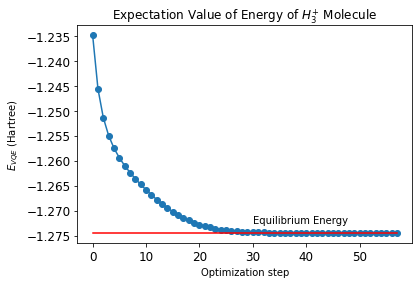

In [63]:
import matplotlib.pyplot as plt

fig = plt.figure()

# Plotting expected value of energy of H_3^{+}
E_vqe = np.array(energy)

plt.plot(range(len(E_vqe)), E_vqe, marker = 'o')
plt.plot(range(len(E_vqe)), np.full(len(E_vqe), -1.2744375 ), color="red")

plt.xlabel("Optimization step")
plt.ylabel("$E_{VQE}$ (Hartree)")
plt.text(30,-1.2725, r"Equilibrium Energy")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title("Expectation Value of Energy of $H_3^{+}$ Molecule")
plt.show()

Text(0.5, 1.0, 'Bond length of $H_3^{+}$ Molecule')

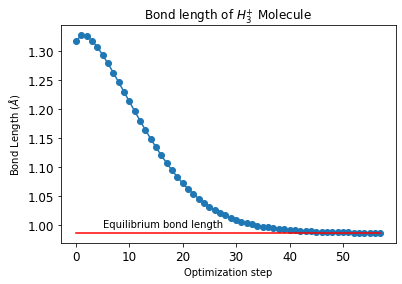

In [64]:
# Plotting the bond length of H_3^{+}
plt.figure()

bondlength = np.array(bond_length12)

plt.plot(range(len(bondlength)), bondlength, marker = 'o')
plt.plot(range(len(bondlength)), np.full(len(bondlength), 0.986), color="red")

# plt.ylim([0.965, 0.99])
plt.xlabel("Optimization step")
plt.ylabel("Bond Length ($\AA$)")
plt.text(5, 0.995, r"Equilibrium bond length")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title("Bond length of $H_3^{+}$ Molecule")

## **Watch the VQE Algorithm in Action!!!! 😏**
The following series of subplots, show the three H-atoms of $H_3^{+}$, as multi-coloured circles, as the algorithm works. 

**NOTE:** The radius of the circle, is not indicative of the actual radius of the H-atom. 

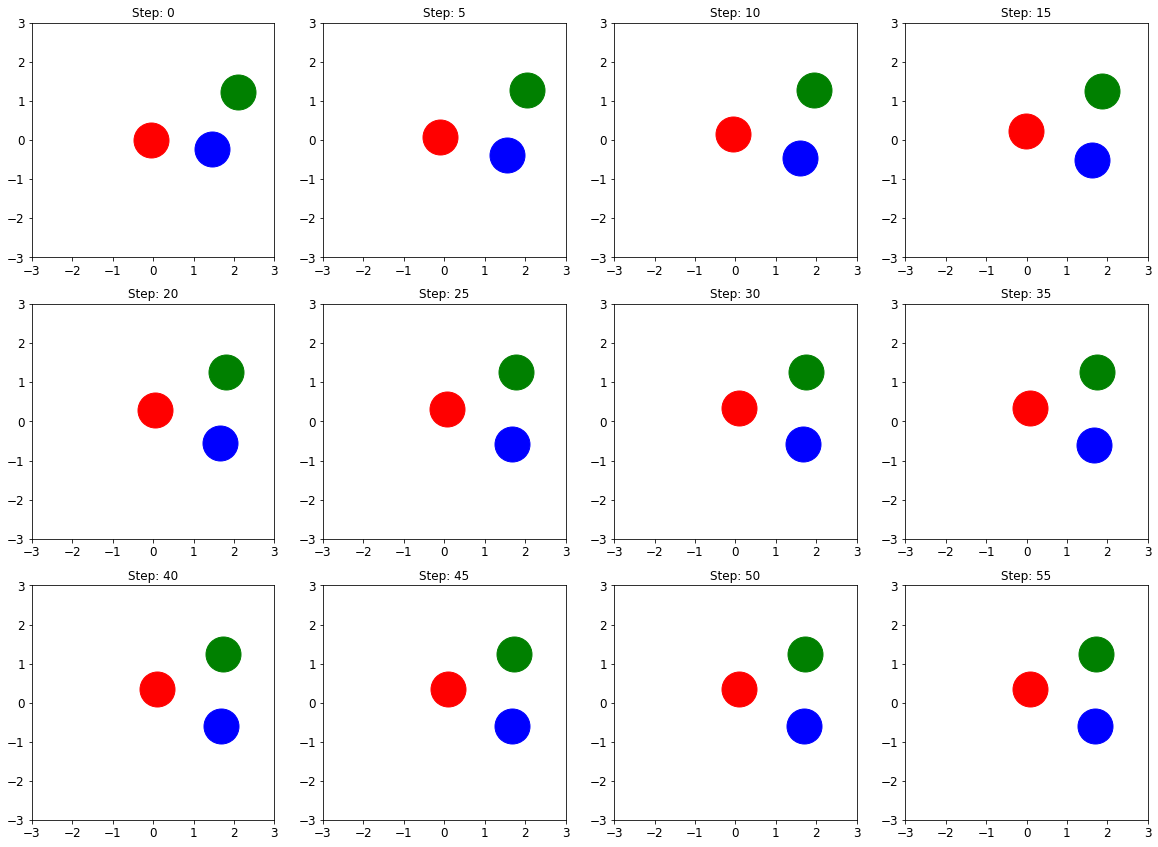

In [66]:
# Plotting the H-atoms on a 2D x - y plane for visualization of the gradient descent process
plt.figure(figsize=(20,25))

for i in range(len(x1)):
  plt.subplot(5,4,(i+1))

  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)

  # Set the x and y limits accordingly, if you are changing the initial coordinate values of the atoms
  limit = 3
  plt.xlim([-limit,limit])
  plt.ylim([-limit,limit])

  plt.plot(x1[i], y1[i], 'ro',linewidth=2, markersize = 35)
  plt.plot(x2[i], y2[i], 'go',linewidth=2, markersize = 35)
  plt.plot(x3[i], y3[i], 'bo',linewidth=2, markersize = 35)

  plt.title('Step: %i'% (5*(i)), fontsize=12)

# **Conclusion**


In [68]:
print("Equilibrium values as calculated by the Variational Quantum Algorithm")
myTable2 = PrettyTable(["Energy (Hartree)", "Bond Length H1-H2 (A)", "Bond Length H2-H3 (A)", "Bond Length H3-H1 (A)", "Theta 1 (rad)", "Theta 2 (rad)"])
myTable2.add_row([energy[n], bond_length12[n], bond_length23[n], bond_length31[n], theta[0], theta[1] ])
print(myTable2)

Equilibrium values as calculated by the Variational Quantum Algorithm
+---------------------+-----------------------+-----------------------+-----------------------+---------------------+---------------------+
|   Energy (Hartree)  | Bond Length H1-H2 (A) | Bond Length H2-H3 (A) | Bond Length H3-H1 (A) |    Theta 1 (rad)    |    Theta 2 (rad)    |
+---------------------+-----------------------+-----------------------+-----------------------+---------------------+---------------------+
| -1.2744375917889832 |   0.9861182642812559  |   0.9854340531347746  |   0.9854337868872547  | 0.19231291441431386 | 0.19292950108827045 |
+---------------------+-----------------------+-----------------------+-----------------------+---------------------+---------------------+


The applicability of Variational Quantum Algorithm could also be extended to target Hamiltonians of other molecules and to get a deeper insight in other molecular properties.

To summarize:

<p align="center">
<img src='https://drive.google.com/uc?id=14Jz6T4kGue8m7dMQ2xppZOTbSipzp9D1' width="350"/>
</p>